### РОССИЙСКИЙ УНИВЕРСИТЕТ ДРУЖБЫ НАРОДОВ

#### Факультет физико-математических и естественных наук  
#### Кафедра информационных технологий 

## ОТЧЕТ ПО ЛАБОРАТОРНОЙ РАБОТЕ №6

#### Дисциплина: Интеллектуальный анализ данных

##### Студент:  Николаев Александр Викторович
##### Группа:   НФИбд-01-17

## Москва 2020
***

### Вариант №15

In [1]:
import pandas as pd
import numpy as np

from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve, roc_auc_score

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

seed = 42 # fix random_state to determinate results

1. Считаем данные из [репозитория UCI](http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data). Target columns - cylinders

In [2]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
columns = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model', 'origin', 'car']
target = 'cylinders'
data = pd.read_csv(url, header=None, delim_whitespace=True, names=columns)
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin,car
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


2. Посмотрим на данные, пропуски и прочее.

In [3]:
data.replace('?', np.nan, inplace=True)
data.isna().sum()

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model           0
origin          0
car             0
dtype: int64

Пропусков в метках класса нет

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    392 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model         398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car           398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


Преобразуем `horsepower` в float и заменим пропуски на медиану

In [5]:
data['horsepower'] = data['horsepower'].astype(np.float64)
data['horsepower'] = data['horsepower'].fillna(np.nanmedian(data['horsepower']))

Выкиним признак car, т.к. он нечисловой

In [6]:
data.drop(columns=['car'], inplace=True)

In [7]:
data

,mpg,cylinders,displacement,horsepower,weight,acceleration,model,origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


Разделим данные на признаки и таргет

In [8]:
X = data.drop(columns=[target])
y = data[target]

3. Построим и визуализируем матрицу коллеряции. Удалим из набора признаки с большой по модулю корреляцией.

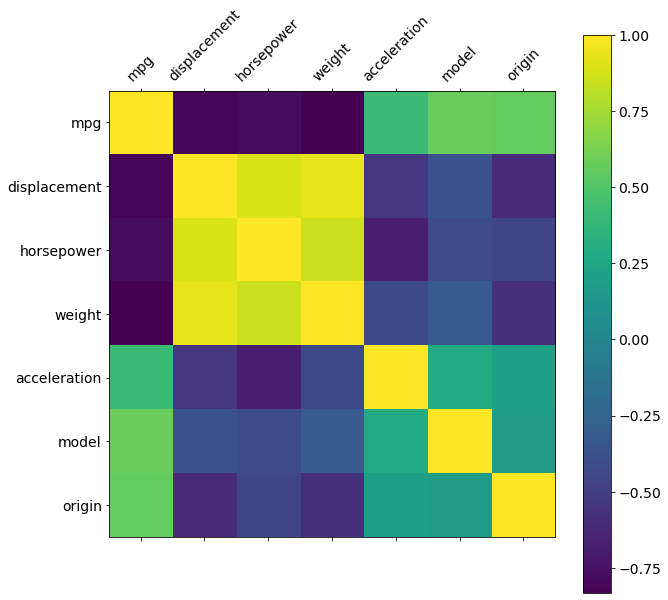

In [9]:
f = plt.figure(figsize=(10, 10))

plt.matshow(X.corr(), fignum=f.number)
plt.xticks(range(X.shape[1]), X.columns, fontsize=14, rotation=45)
plt.yticks(range(X.shape[1]), X.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
# plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [10]:
X.corr()

,mpg,displacement,horsepower,weight,acceleration,model,origin
mpg,1.000000,-0.804203,-0.773453,-0.831741,0.420289,0.579267,0.563450
displacement,-0.804203,1.000000,0.895778,0.932824,-0.543684,-0.370164,-0.609409
horsepower,-0.773453,0.895778,1.000000,0.862442,-0.686590,-0.413733,-0.452096
weight,-0.831741,0.932824,0.862442,1.000000,-0.417457,-0.306564,-0.581024
acceleration,0.420289,-0.543684,-0.686590,-0.417457,1.000000,0.288137,0.205873
model,0.579267,-0.370164,-0.413733,-0.306564,0.288137,1.000000,0.180662
origin,0.563450,-0.609409,-0.452096,-0.581024,0.205873,0.180662,1.000000


Видим высокую корреляцию между `mpg`, `displacement`, `horsepower` и `weight`. Оставим из них только один признак, например, `displacement`

In [11]:
X.drop(columns=['mpg', 'horsepower', 'weight'], inplace=True)

4. Посмотрим сколько меток в таргете, и если что, объединим так, чтобы сбалансировать классы.

In [12]:
y.value_counts()

4    204
8    103
6     84
3      4
5      3
Name: cylinders, dtype: int64

В столбце с меткой классой больше двух уникальных меток, объединим следующим образом: метка 4 -> метка 0, а 3,5,6,8 объединим в одну метку -> 1. Тогда получится примерно баланс. (хотя по хорошему, т.к. это количество целиндров, то лучше объединять по другому принципу, например, разбить на два диапазона: мало целиндров (3-4) и много (5-8), но тогда будет сильный дисбаланс)

In [13]:
mask = y == 4
y[mask] = 0
y[~mask] = 1
y.value_counts()

0    204
1    194
Name: cylinders, dtype: int64

5. Воспользуемся RFE и логистической регрессией, оставив в наборе не менее двух признаков.

In [14]:
model = LogisticRegression(max_iter=1000, random_state=seed)
rfe = RFE(model)
fit = rfe.fit(X, y)

In [15]:
print("Число признаков: %d" % fit.n_features_)
print("Выбранные признаки: %s" % fit.support_)
print("Ранг признаков: %s" % fit.ranking_)

Число признаков: 2
Выбранные признаки: [False  True False  True]
Ранг признаков: [2 1 3 1]


In [16]:
X = X.loc[:, fit.support_]

6. Масштабируем признаки на отрезок от 0 до 1

In [17]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

7. Разделим выборку на трейн и тест в соотношении 7:3 и обучим классификаторы: наивный байесовский классификатор, логистическая регрессия, линейный дискриминантный анализ и метод опорных векторов.

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y.values, test_size=0.3, random_state=42)

nb = GaussianNB()
nb.fit(X_train, y_train)

lr = LogisticRegression(max_iter=500, random_state=42)
lr.fit(X_train, y_train)

lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

svm = SVC(kernel='linear', probability=True, random_state=42) # for linear SVC
svm.fit(X_train, y_train);

8. Визуализируем для каждого из классификаторов границу решения, подписывая оси и рисунок и создавая легенду для меток классов набора данных.

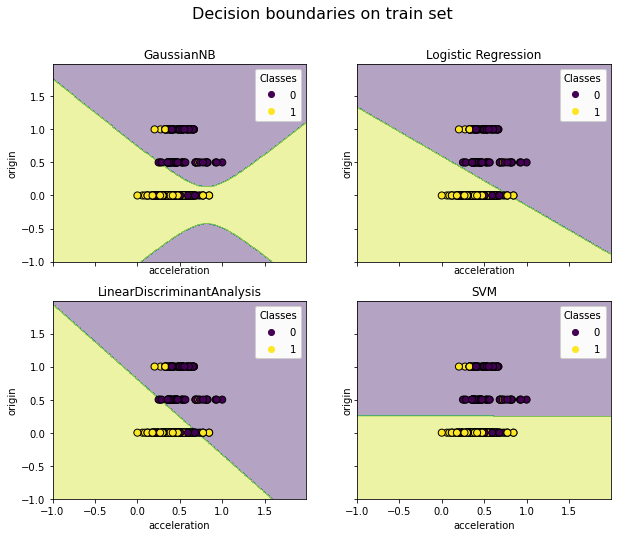

In [19]:
x_min, x_max = X_train[:, 0].min() - 1, X_train[:, 0].max() + 1
y_min, y_max = X_train[:, 1].min() - 1, X_train[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
f, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))
f.suptitle('Decision boundaries on train set', fontsize=16)

for ax, clf, tt in zip(axes.ravel(), [nb, lr, lda, svm], ['GaussianNB', 'Logistic Regression',
                                                  'LinearDiscriminantAnalysis', 'SVM']):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    scatter = ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, edgecolor='k')
    ax.set_title(tt)
    ax.set_xlabel('acceleration')
    ax.set_ylabel('origin')
    legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
    ax.add_artist(legend)
plt.show()

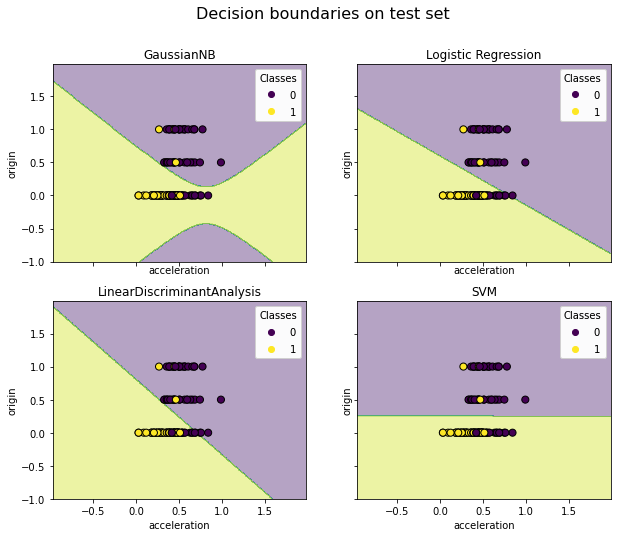

In [20]:
x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                     np.arange(y_min, y_max, 0.01))
f, axes = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))
f.suptitle('Decision boundaries on test set', fontsize=16)

for ax, clf, tt in zip(axes.ravel(), [nb, lr, lda, svm], ['GaussianNB', 'Logistic Regression',
                                                  'LinearDiscriminantAnalysis', 'SVM']):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    ax.contourf(xx, yy, Z, alpha=0.4)
    scatter = ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=50, edgecolor='k', label=['class 1', 'class 0'])
    ax.set_title(tt)
    ax.set_xlabel('acceleration')
    ax.set_ylabel('origin')
    legend = ax.legend(*scatter.legend_elements(),
                    loc="upper right", title="Classes")
    ax.add_artist(legend)
plt.show()

9. Визуализируем на одном рисунке ROC кривые для каждого из классификаторов, подписывая оси и рисунок и создавая легенду для методов бинарной классификации.

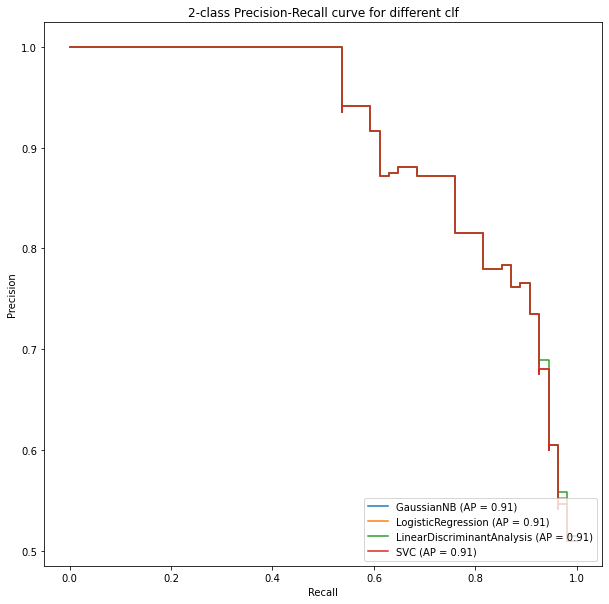

In [21]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
plot_precision_recall_curve(nb, X_test, y_test, ax=ax)
plot_precision_recall_curve(lr, X_test, y_test, ax=ax)
plot_precision_recall_curve(lda, X_test, y_test, ax=ax)
plot_precision_recall_curve(svm, X_test, y_test, ax=ax)
ax.set_title('2-class Precision-Recall curve for different clf')
plt.legend(loc='lower right');

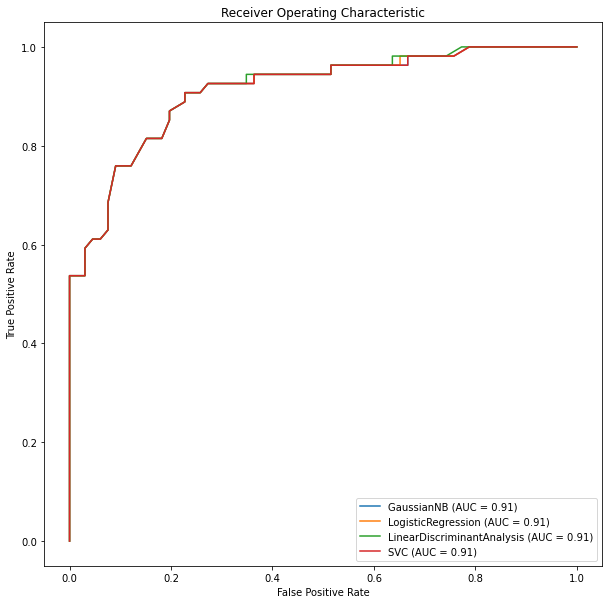

In [22]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot()
plot_roc_curve(nb, X_test, y_test, ax=ax)
plot_roc_curve(lr, X_test, y_test, ax=ax)
plot_roc_curve(lda, X_test, y_test, ax=ax)
plot_roc_curve(svm, X_test, y_test, ax=ax)
ax.set_title('Receiver Operating Characteristic')
plt.legend(loc='lower right');

10. Определим лучший метод бинарной классификации набора данных по показателю ROC_AUC (площади под ROC кривой).

In [23]:
models = [nb, lr, lda, svm]
names = ['GaussianNB', 'Logistic Regression', 'LinearDiscriminantAnalysis', 'SVM']
print('Roc-auc scores:\n')
for model, name in zip(models, names):
    preds = model.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, preds)
    print(f'{name:<30} {score:<10}')

Roc-auc scores:

GaussianNB                     0.9117564534231201
Logistic Regression            0.9120370370370372
LinearDiscriminantAnalysis     0.9128787878787878
SVM                            0.9117564534231201


Видим, что лучше всего себя показал линейный дискриминантный анализ, площадь под roc кривой = 0.9128

Хотя результаты сильно зависят от того, как именно выборка разбилась на трейн и тест, поэтому более честно было бы использовать скользящий контроль + немного подобрать параметры для каждой модели